# About

Script to generate the figures pertaining to large-N dimensional injury resilience. Shows the plots over time for a single trial at a specific injury level, and a compiled plot showing where multiple trials converge in terms of asymptotic frequency and standard deviation pre-injury and post-injury. Import .mat files generated from 'sec4_ND_injury.m'.

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import scipy.integrate as integrate
from scipy import stats
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import matplotlib.colors as clr
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files (for fig.4d)
import_folder = 'sec4_ND_injury'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'matlab', 'data', import_folder)
dir_im_plas = os.path.join(dir_im, 'plas')
dir_im_noplas = os.path.join(dir_im, 'noplas')

filenames_plas = os.listdir(dir_im_plas)
filenames_noplas = os.listdir(dir_im_noplas)
filenames_plas.remove('parameters.mat')
filenames_noplas.remove('parameters.mat')

# Import data

## Parameters

In [3]:
dir_par = os.path.join(dir_im_plas, 'parameters.mat')
dict_par = sio.loadmat(dir_par)

N = dict_par['N'][0,0]
g = dict_par['g'][0,0]
w0 = dict_par['omega0'][0,0]
alphatau = dict_par['alphatau'][0,0]
gain = dict_par['gain'][0,0]
tau0 = dict_par['tau0'][0,0]
t0 = dict_par['t0'][0,0]
tf = dict_par['tf'][0,0]
epsilon = dict_par['epsilon'][0,0]

initstd = dict_par['hist_std'][0,0]
initOmega = dict_par['hist_freq'][0,0]
asy = dict_par['asy'][0,0]

tinjs = dict_par['tinjs'][0,0]
tinjf = dict_par['tinjf'][0,0]

inj_arr = np.reshape(dict_par['inj_arr'], -1)

## Processing function

In [4]:
def compile_data(directory, filenames, ind0):
    '''
    Returns the asymptotic arrays for frequency and standard deviation of phases pre-injury and post-injury.
    Also returns the solution arrays, and the damage matrix and mollfier function.
    '''
    # Compiled arrays
    asyOmegas_pre = np.zeros(len(filenames))
    asydeltas_pre = np.zeros(len(filenames))
    asyOmegas_post = np.zeros(len(filenames))
    asydeltas_post = np.zeros(len(filenames))

    for i in range(len(filenames)):

        # Import .mat file
        filename = filenames[i]
        dir_mat = os.path.join(directory, filename)
        dict_mat =  sio.loadmat(dir_mat)

        # Get g, tau0 indices
        ind_file = filename.split('.')[0]
        ind = int(ind_file)

        # Compile solution dictionary
        sol = {'t': np.reshape(dict_mat['t'], -1),
               'y': dict_mat['y'],
               'yp': dict_mat['yp'],
               'tau': dict_mat['tau'],
               'taup': dict_mat['taup']
              }

        phases_pre_mod = np.reshape(dict_mat['phases_pre'], -1)
        phases_pre_mod = asylib.mod_pi(phases_pre_mod)

        phases_post_mod = np.reshape(dict_mat['phases_post'], -1)
        phases_post_mod = asylib.mod_pi(phases_post_mod)
    
        asyOmega_pre = dict_mat['Omega_pre'][0,0]
        asyOmega_post = dict_mat['Omega_post'][0,0]
        
        asyOmegas_pre[i] = asyOmega_pre
        asyOmegas_post[i] = asyOmega_post
        asydeltas_pre[i] = np.sqrt(np.var(phases_pre_mod))
        asydeltas_post[i] = np.sqrt(np.var(phases_post_mod))

        if ind == ind0:
            sol0 = sol.copy()
            A_inj = dict_mat['A_inj'] # Which ones are not injured
            mollifier = np.reshape(dict_mat['molarr'], -1)
            
            # Define transitional Omega*t
            Omegalinear = (asyOmega_pre*mollifier + asyOmega_post*(1 - mollifier))*sol0['t']
            arrlinear = Omegalinear[:,None]
            arrphases = sol0['y'] - arrlinear
    
    # Return
    d = {'asyOmegas_pre': asyOmegas_pre,
         'asyOmegas_post': asyOmegas_post,
         'asydeltas_pre': asydeltas_pre,
         'asydeltas_post': asydeltas_post,
         'sol': sol0,
         'A_inj': A_inj,
         'mollifier': mollifier,
         'arrphases': arrphases
        }
    
    return d

## Process arrays

In [5]:
# Select which injury index to plot:
ind0 = 8

plas = compile_data(dir_im_plas, filenames_plas, ind0)
noplas = compile_data(dir_im_noplas, filenames_noplas, ind0)

# Rename arrays to plot
A_inj = plas['A_inj']
A_0 = np.ones(A_inj.shape)
A_double = np.concatenate((A_0, A_inj), axis=1)
mollifier = plas['mollifier']

# Solutions
solp = plas['sol']
arrphases_p = plas['arrphases']
solnp = noplas['sol']
arrphases_np = noplas['arrphases']

# Delay histogram
ind_inj = np.argmin(np.abs(solp['t'] - (tinjs-1)))
ind_f = np.argmin(np.abs(solp['t'] - (tinjf-1)))
A_inj_flat = np.reshape(A_inj.T, -1)

Tau0 = solp['tau'][0]
Tau1 = solp['tau'][ind_inj]
Tau2 = solp['tau'][-1]
Tau2 = Tau2[A_inj_flat > 0.5]

# TEST
Tau_sol = solp['tau'][:, A_inj_flat > 0.5]

# Round up negatives
Tau1 = np.maximum(Tau1, np.zeros(Tau1.shape))
Tau2 = np.maximum(Tau2, np.zeros(Tau2.shape))

# Maximum delay
Tau1_max = np.max(Tau1)
Tau2_max = np.max(Tau2)
Tau_max = np.max((Tau1_max, Tau2_max))

# Asymptotic arrays
asyOmegas_post_p = plas['asyOmegas_post']
asydeltas_post_p = plas['asydeltas_post']
asyOmegas_post_np = noplas['asyOmegas_post']
asydeltas_post_np = noplas['asydeltas_post']

# Figure 1 

## Options

In [6]:
# Plot positions [left, bottom, width, height] 
bbox0 = [0.1, 0.70, 0.40, 0.9] # Fig 6a: Topology comparison
bbox1 = [0.6, 0.70, 0.40, 0.9] # Fig 6b: Decay function

# Line options
inj_options = {'linewidth': 4.0,
               'alpha': 1.0,
               'color': 'red'
              }

# Alphas
alpha1 = 0.6
alpha_inj = 0.3

## Generate figure

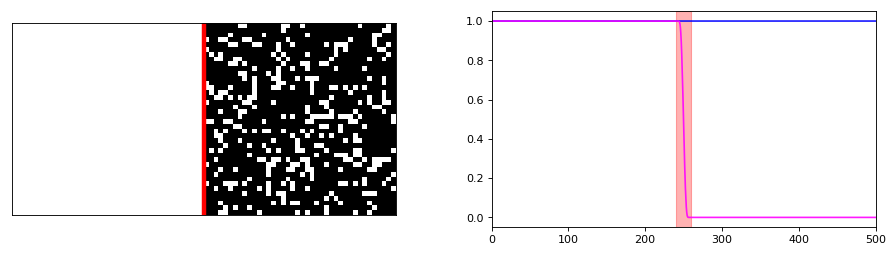

In [7]:
fig, ax = plt.subplots(2, figsize=(12,3), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)

# Figure A
ax[0].imshow(1-A_double, cmap='Greys')
ax[0].axvline(x=N-1/2, **inj_options)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Figure B
ax[1].plot(solp['t'], mollifier, color='magenta', alpha=0.9, zorder=2)
ax[1].plot(solp['t'], np.ones(solp['t'].shape), color='blue', alpha=0.9, zorder=1)

# Figure B edit
ax[1].set_xlim(left=t0, right=tf)
ax[1].axvspan(tinjs, tinjf, alpha=alpha_inj, color='red')

# Figure 2

## Options

In [8]:
# Plot positions [left, bottom, width, height] 
bbox0 = [0.1, 0.70, 0.90, 0.20] # Fig 6b: Histogram of delays
bbox1 = [0.1, 0.40, 0.40, 0.20] # Fig 6c: Frequency over time (non-plastic)
bbox2 = [0.6, 0.40, 0.40, 0.20] # Fig 6d: Frequency over time (plastic)
bbox3 = [0.1, 0.1, 0.40, 0.20] # Fig 6e: sin phase over time (non-plastic)
bbox4 = [0.6, 0.1, 0.40, 0.20] # Fig 6f: sin phase over time (plastic)

line_options = {'linewidth': 1.0,
                'alpha': 0.6
               }
lw_hist = 1.0

# Colourmap
colormap_p = plt.cm.get_cmap('cool')
colormap_np = plt.cm.get_cmap('OrRd')
colorlist_p = [colormap_p(i) for i in np.linspace(0, 0.99, N)]
colorlist_np = [colormap_np(i) for i in np.linspace(0, 0.99, N)]

# Histogram colours
alpha_col = 0.2
col0 = 'black'
col1 = 'orange'
col2 = 'blue'
col0_alp = clr.to_rgba(col0, alpha=alpha_col)
col1_alp = clr.to_rgba(col1, alpha=alpha_col)
col2_alp = clr.to_rgba(col2, alpha=alpha_col)

# Bins
BINS = np.arange(0, np.ceil(Tau_max), 0.5)
bin_range = (0, 8)
num_bins = 30

## Generate figure

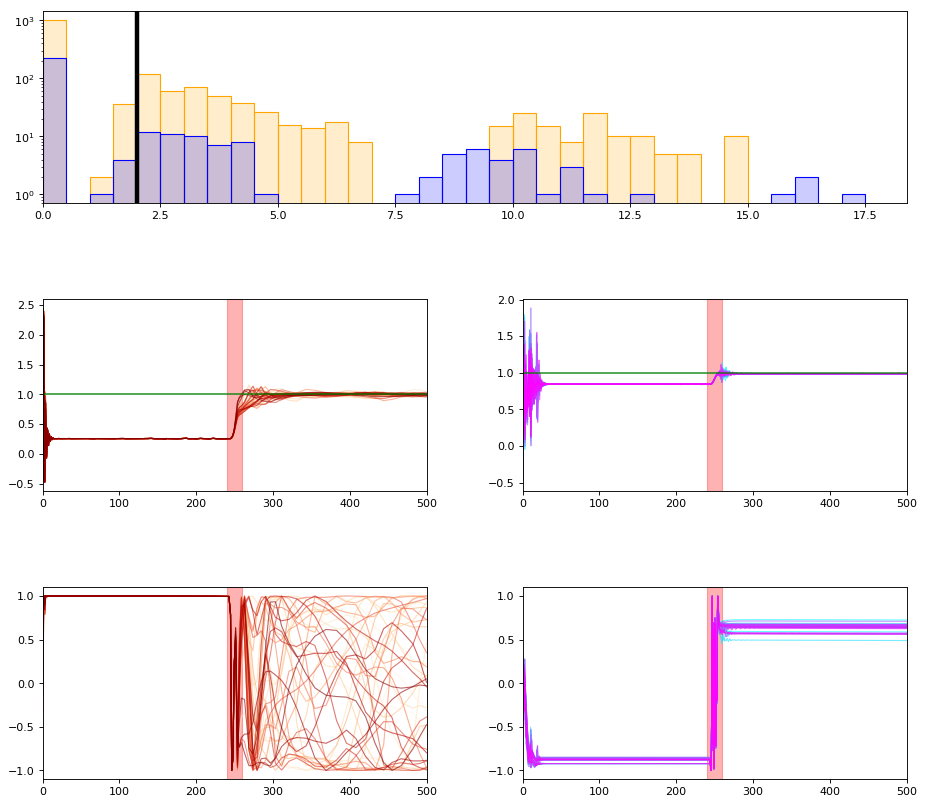

In [9]:
fig, ax = plt.subplots(5, figsize=(12,12), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)
ax[4].set_position(bbox4)

# Figure A
# ax[0].hist(Tau0, bins=BINS, density=False, log=True, color=col0_alp, edgecolor=col0, linewidth=lw_hist)
BINS1 = ax[0].hist(Tau1, bins=BINS, density=False, log=True, color=col1_alp, edgecolor=col1, linewidth=lw_hist)
BINS2 = ax[0].hist(Tau2, bins=BINS, density=False, log=True, color=col2_alp, edgecolor=col2, linewidth=lw_hist)
ax[0].axvline(x=tau0, linewidth=4.0, color=col0, zorder=1)

# Figure B
ax[1].set_prop_cycle(color=colorlist_np)
ax[1].plot(solnp['t'], solnp['yp'], **line_options)
ax[1].axhline(y=w0, color='green', alpha=0.8)

# Figure C
ax[2].set_prop_cycle(color=colorlist_p)
ax[2].plot(solp['t'], solp['yp'], **line_options)
ax[2].axhline(y=w0, color='green', alpha=0.8)

# Figure D
ax[3].set_prop_cycle(color=colorlist_np)
ax[3].plot(solnp['t'], np.sin(arrphases_np), **line_options)

# Figure E
ax[4].set_prop_cycle(color=colorlist_p)
ax[4].plot(solp['t'], np.sin(arrphases_p), **line_options)

# Axis edit
ax[0].set_xlim(left=0)
ax[1].set_xlim(left=t0, right=tf)
ax[2].set_xlim(left=t0, right=tf)
ax[3].set_xlim(left=t0, right=tf)
ax[4].set_xlim(left=t0, right=tf)

ax[1].axvspan(tinjs, tinjf, alpha=alpha_inj, color='red')
ax[2].axvspan(tinjs, tinjf, alpha=alpha_inj, color='red')
ax[3].axvspan(tinjs, tinjf, alpha=alpha_inj, color='red')
ax[4].axvspan(tinjs, tinjf, alpha=alpha_inj, color='red')

# Figure 3

## Options

In [10]:
# Plot positions [left, bottom, width, height] 
bbox0 = [0.1, 0.70, 0.40, 0.9] # Fig 6a: Asymptotic Omegas
bbox1 = [0.6, 0.70, 0.40, 0.9] # Fig 6b: Asymptotic deltas

## Generate figure

(0.2191558936156501, 1.125)

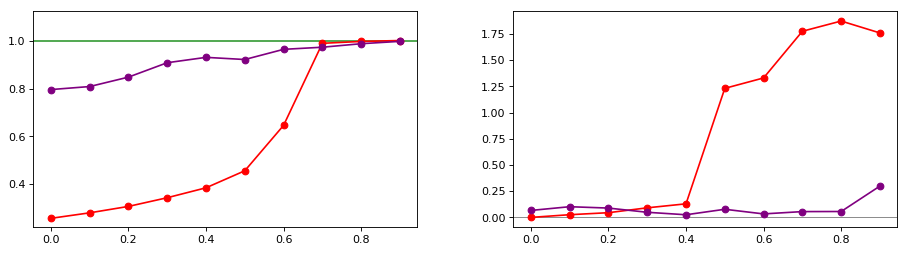

In [13]:
fig, ax = plt.subplots(2, figsize=(12,3), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)

ax[0].plot(inj_arr, asyOmegas_post_p, marker='o', color='purple', zorder=2)
ax[0].plot(inj_arr, asyOmegas_post_np, marker='o', color='red', zorder=1)
ax[0].axhline(y=w0, color='green', alpha=0.8, zorder=0)

ax[1].plot(inj_arr, asydeltas_post_p, marker='o', color='purple', zorder=2)
ax[1].plot(inj_arr, asydeltas_post_np, marker='o', color='red', zorder=1)
ax[1].axhline(y=0, color='black', linewidth=0.5, alpha=0.8, zorder=0)

ax[0].set_ylim(top=w0+g/12)